In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import os 
import librosa 
from IPython.display import Audio
import tensorflow as tf

In [2]:
paths = [] 
labels = []

In [3]:
for dirname, _, filenames in os.walk(r"D:\multi_model_project\voice_emotion_detection\TESS Toronto emotional speech set data"):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split("_")[-1]
        labels.append(label.split(".")[0])


In [4]:
df = pd.DataFrame({'path':paths,'label':labels})

In [5]:
df.head(3)

,path,label
0,D:\multi_model_project\voice_emotion_detection...,angry
1,D:\multi_model_project\voice_emotion_detection...,angry
2,D:\multi_model_project\voice_emotion_detection...,angry


In [6]:
df.value_counts

<bound method DataFrame.value_counts of                                                    path  label
0     D:\multi_model_project\voice_emotion_detection...  angry
1     D:\multi_model_project\voice_emotion_detection...  angry
2     D:\multi_model_project\voice_emotion_detection...  angry
3     D:\multi_model_project\voice_emotion_detection...  angry
4     D:\multi_model_project\voice_emotion_detection...  angry
...                                                 ...    ...
5595  D:\multi_model_project\voice_emotion_detection...    sad
5596  D:\multi_model_project\voice_emotion_detection...    sad
5597  D:\multi_model_project\voice_emotion_detection...    sad
5598  D:\multi_model_project\voice_emotion_detection...    sad
5599  D:\multi_model_project\voice_emotion_detection...    sad

[5600 rows x 2 columns]>

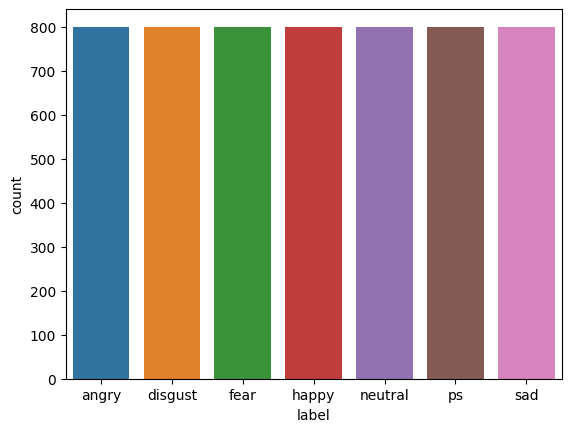

In [7]:
sns.countplot(x='label',data=df)
plt.show()

In [8]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift    


In [9]:
augmentations = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
])

In [10]:

  
def pad_or_truncate(samples, max_len=16000):
    if len(samples) > max_len:
        return samples[:max_len]
    elif len(samples) < max_len:
        return np.pad(samples, (0, max_len - len(samples)), 'constant')
    else:
        return samples

In [11]:
#extracting the features 
def extract_feature(data, sr=16000, max_frames=160):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40)

    # Pad or truncate along time axis (axis=1)
    if mfcc.shape[1] > max_frames:
        mfcc = mfcc[:, :max_frames]
    elif mfcc.shape[1] < max_frames:
        pad_width = max_frames - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')

    return mfcc


In [12]:
def preprocess_audio(audio_path, sr=16000, max_len=16000):
    samples, _ = librosa.load(audio_path, sr=sr)
    samples = augmentations(samples=samples, sample_rate=sr )
    samples = pad_or_truncate(samples, max_len)
    mfcc = extract_feature(samples, sr=16000, max_frames=160)

    return mfcc

In [13]:
mfcc_features = []
valid_labels = []


In [14]:
for indx, row in df.iterrows():
    try:
        mfcc = preprocess_audio(row['path'])
        mfcc_features.append(mfcc)
        valid_labels.append(row['label'])
    except Exception as e:
        print(e)
        pass    

In [15]:
max_len = max([mf.shape[0] for mf in mfcc_features])

# Pad sequences
X = np.array([
    np.pad(mf, ((0, max_len - mf.shape[0]), (0, 0)), mode='constant')
    for mf in mfcc_features
])
print("Input shape (samples, time_steps, n_mfcc):", X.shape)

Input shape (samples, time_steps, n_mfcc): (5600, 40, 160)


In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(valid_labels)
print("Output shape (samples):", y.shape)

Output shape (samples): (5600,)


In [17]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout ,Conv1D,MaxPooling1D,Flatten
from keras.optimizers import Adam

In [18]:
model  = Sequential()


In [19]:
from tensorflow.keras import models, layers, regularizers

model = models.Sequential([
    layers.Input(shape=X.shape[1:]),  # (time_steps, n_mfcc)

    layers.Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    # One more Conv layer is enough
    layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),

    layers.Dense(len(np.unique(y)), activation='softmax')
])


In [22]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

In [24]:
history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop, lr_reduce])

Epoch 1/100
140/140 [==============================] - 20s 55ms/step - loss: 1.3333 - accuracy: 0.6913 - val_loss: 0.7862 - val_accuracy: 0.8214 - lr: 0.0010
Epoch 2/100
140/140 [==============================] - 10s 71ms/step - loss: 0.4991 - accuracy: 0.9259 - val_loss: 0.2851 - val_accuracy: 0.9804 - lr: 0.0010
Epoch 3/100
140/140 [==============================] - 11s 77ms/step - loss: 0.3052 - accuracy: 0.9547 - val_loss: 0.1653 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 4/100
140/140 [==============================] - 10s 73ms/step - loss: 0.2110 - accuracy: 0.9703 - val_loss: 0.1491 - val_accuracy: 0.9839 - lr: 0.0010
Epoch 5/100
140/140 [==============================] - 10s 68ms/step - loss: 0.1657 - accuracy: 0.9754 - val_loss: 0.0945 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 6/100
140/140 [==============================] - 10s 68ms/step - loss: 0.1142 - accuracy: 0.9871 - val_loss: 0.0841 - val_accuracy: 0.9929 - lr: 0.0010
Epoch 7/100
140/140 [==============================]

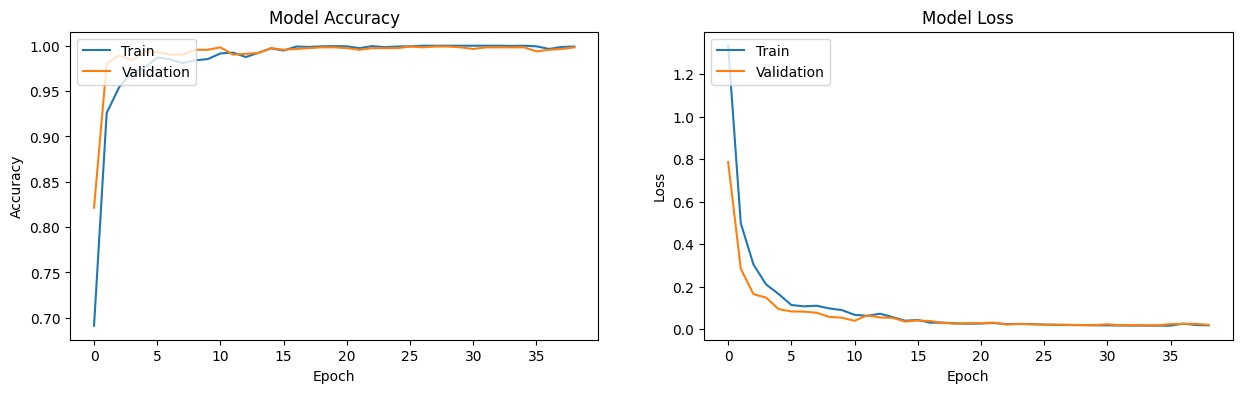

In [25]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
def predict_emotion(audio_path, model, label_encoder, sr=16000, max_len=16000, max_frames=160):
    samples, _ = librosa.load(audio_path, sr=sr)
    samples = augmentations(samples=samples, sample_rate=sr)
    samples = pad_or_truncate(samples, max_len)
    
    mfcc = extract_feature(samples, sr=sr, max_frames=max_frames)

    # Ensure shape is (1, 40, 160)
    mfcc = mfcc[np.newaxis, :, :]  # Remove transpose!

    # Predict
    prediction = model.predict(mfcc)
    predicted_index = np.argmax(prediction)
    predicted_label = label_encoder.inverse_transform([predicted_index])[0]

    return predicted_label


In [27]:
predict_emotion("TESS Toronto emotional speech set data/YAF_happy/YAF_base_happy.wav",model=model, label_encoder=le)

1/1 [==============================] - 1s 529ms/step


'happy'

In [28]:
model.save('model_3.h5')

In [ ]:
df